### Exploratory analysis to better understand the peak flooding date.

---
1. Imports, loading, and preprocessing
---

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Go to root repo directory
os.chdir('..')

# Import custom functions 
from scripts.d02_processing import FE_clean_data as cd
from scripts.d03_analysis import FE_fit_function as ff
from scripts.d01_data import FE_load_data as ld

In [2]:
FNAME = 'Sentinel-1-BGD-Flooding-updated.xlsx' # File name of the flood extent data
df0 = ld.read_data(FNAME)

In [3]:
ADM_GRP = 'ADM3_EN' # Admin level to group by
df1 = cd.group_df(df0, ADM_GRP)

---
2. Demonstrate functions and take a look at the sample results 
---

Original peak: 2020-07-21
Fitted peak Gaussian: 2020-07-30
Fitted peak Polynomial: 2020-08-04


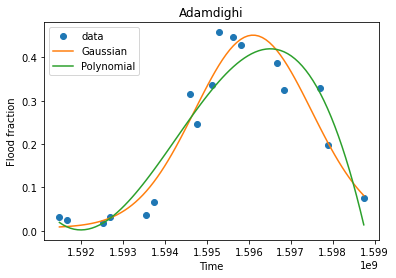

In [4]:
# 0. Select admin region from the grouped data
df2 = cd.select_df(df1, df1[ADM_GRP].unique()[0])

# 1. Get the x and y
x,y = ff.get_xy(df2)[0], ff.get_xy(df2)[1]

# 2. Fit function to generate new data at daily intervals
x_new = np.linspace(x[0], x[-1], 85)
y_new_g = ff.gauss(x_new, *ff.gauss_fit(x, y))
y_new_p = ff.poly_fit(x_new,x, y, 3)

# 3. Plot the actual and fitted data
plt.plot(x, y, 'o', label='data')
plt.plot(x_new, y_new_g, label='Gaussian')
plt.plot(x_new, y_new_p, label='Polynomial')
plt.title(df1[ADM_GRP].unique()[0])
plt.legend()
plt.xlabel('Time')
plt.ylabel('Flood fraction')

# 4. Calculate the peak dates 
print('Original peak: ' + ff.get_peak(x,y))
print('Fitted peak Gaussian: ' + ff.get_peak(x_new,y_new_g))
print('Fitted peak Polynomial: ' + ff.get_peak(x_new,y_new_p))

---
3. Fit the function, calculate error, and get peak flood dates
---

In [5]:
results = pd.DataFrame([])

for adm in df1[ADM_GRP].unique():

    # Fit the data 
    df2 = cd.select_df(df1, adm)  # New grouped dataframe
    x,y = ff.get_xy(df2)[0], ff.get_xy(df2)[1]  # Get the x and y 
    x_new = np.linspace(x[0], x[-1], 85)  # Generate new x data (at daily intervals)
    
    #if len(x)<17:
    #    print(adm)
    #    print(len(x))
    #    continue

    # New y values using same x data to calc the error 
    y_g_old = ff.gauss(x, *ff.gauss_fit(x, y))  # Generate Gaussian fitted y data
    y_p_old = ff.poly_fit(x,x, y, 3)  # Generate polynomial fitted y data - degree 3
    
    # New y values using daily x data to get better peak estimate 
    y_g_new = ff.gauss(x_new, *ff.gauss_fit(x, y))  # Generate Gaussian fitted y data
    y_p_new = ff.poly_fit(x_new, x, y, 3)  # Generate polynomial fitted y data - degree 3
    
    # Calc the rmse to compare poly vs gauss
    rmse_g = ff.rmse(y_g_old, y)
    rmse_p = ff.rmse(y_p_old, y)
    
    # Get the peak dates 
    date_actual = datetime.strptime(ff.get_peak(x,y), "%Y-%m-%d")
    date_g = datetime.strptime(ff.get_peak(x_new, y_g_new), "%Y-%m-%d")
    date_p = datetime.strptime(ff.get_peak(x_new, y_p_new), "%Y-%m-%d")
    
    # Calculate the difference between dates
    act_g = (date_actual - date_g).days
    act_p = (date_actual - date_p).days
    
    # Create dict with the results
    result = {'ADM': adm,
             'RMSE_G': rmse_g,
             'RMSE_P': rmse_p, 
              'PEAK_ACT': date_actual,
              'PEAK_G': date_g,
              'PEAK_P': date_p,
              'DIFF_ACT_G': act_g,
              'DIFF_ACT_P': act_p}
    results = results.append(result, ignore_index=True)

In [35]:
# Save results to csv
results.to_csv('results/flood_peak_estimation_{}.csv'.format(ADM_GRP))

In [6]:
results.head()

,ADM,DIFF_ACT_G,DIFF_ACT_P,PEAK_ACT,PEAK_G,PEAK_P,RMSE_G,RMSE_P
0,Adamdighi,-9.0,-14.0,2020-07-21,2020-07-30,2020-08-04,0.043127,0.057070
1,Bakshiganj,2.0,-2.0,2020-07-27,2020-07-25,2020-07-29,0.037880,0.060957
2,Belkuchi,-6.0,-8.0,2020-07-21,2020-07-27,2020-07-29,0.041485,0.046674
3,Bhurungamari,1.0,-2.0,2020-07-21,2020-07-20,2020-07-23,0.023470,0.037407
4,Bogra Sadar,-4.0,-8.0,2020-07-25,2020-07-29,2020-08-02,0.019377,0.030005


--- 
4. Compare the RMSE values for polynomial vs Gaussian fitting
---

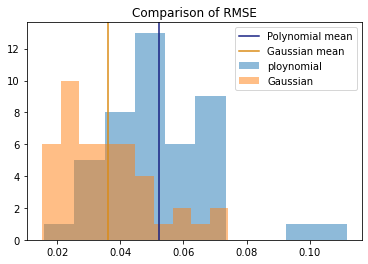

In [7]:
plt.hist(results['RMSE_P'], label='ploynomial', alpha=0.5)
plt.hist(results['RMSE_G'], label='Gaussian', alpha=0.5)
plt.axvline(results['RMSE_P'].mean(), label='Polynomial mean', color='#172082')
plt.axvline(results['RMSE_G'].mean(), label='Gaussian mean', color='#db8c16')
plt.legend()
plt.title('Comparison of RMSE')
plt.show()

---
5. Compare difference in peak date estimation
---

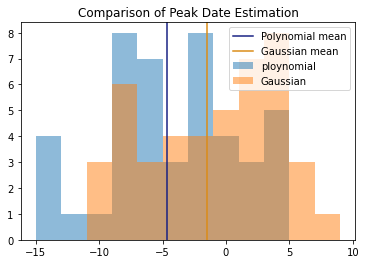

In [8]:
plt.hist(results['DIFF_ACT_P'], label='ploynomial', alpha=0.5)
plt.hist(results['DIFF_ACT_G'], label='Gaussian', alpha=0.5)
plt.axvline(results['DIFF_ACT_P'].mean(), label='Polynomial mean', color='#172082')
plt.axvline(results['DIFF_ACT_G'].mean(), label='Gaussian mean', color='#db8c16')
plt.legend()
plt.title('Comparison of Peak Date Estimation')
plt.show()